In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import lal
from pycbc import waveform
from tqdm import tqdm

# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

In [2]:
c = 3e8
G = 6.67e-11
pc2m = 3.086e16
yr2s = 3.154e7
solarmass = 2e30
from astropy.cosmology import Planck18  # Planck 2018
from scipy.integrate import quad
from scipy import optimize

In [3]:
def dE_df(mass1,mass2,freq=25):
    '''
    Return the dE/df given a mass and distance of a BBH merger
    '''
    #distance_mpc = Planck18.luminosity_distance(z).value
    distance_mpc = 1 # distance cancels out with the denominator in h(f), so it doesn't quite matter here
    delta_f = 1/4
    sptilde, _ = waveform.get_fd_waveform(approximant="IMRPhenomD",
                                              mass1=mass1, 
                                              mass2=mass2, 
                                              delta_f=delta_f,
                                              f_lower=20,
                                              distance=distance_mpc)
    ind = int(freq/ delta_f)
    try:
        sptildedata = sptilde.data[ind]
    except IndexError:
        return 0
    return 8/5*np.pi**2*c**3/G*freq**2*(distance_mpc*1e6*pc2m)**2* \
                (np.abs(sptildedata))**2

# Comparison between a (37,1) solar mass binary merger and a (5,5) binary merger dE/df

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


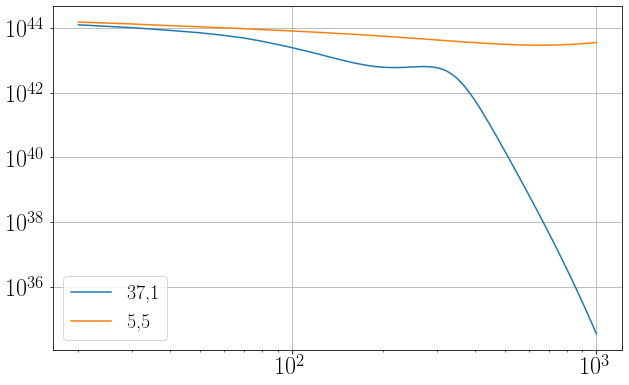

In [4]:
ef1 = []
ef2 = []
freq = np.linspace(20,1000,100)
for f in freq:
    ef1.append( dE_df(37,1,f))
    ef2.append( dE_df(5,5,f))
ef1 = np.array(ef1)
ef2 = np.array(ef2)
plt.plot(freq,ef1,label='37,1')
plt.plot(freq,ef2,label='5,5')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [5]:
t0 = Planck18.age(0).value # age of the Universe
def rate_deltamass(m,f,z):
    '''
    m is mass
    f is fraction of PBH in dark matter
    z is the redshift
    '''
    sigma_eq = 0.005
    t = Planck18.age(z).value
    return 3e6 * (t/t0)**(-34/37) * f**2*(0.7*f**2+sigma_eq**2)**(-21./74)*m**(-32/37)

def rate_twomass(m1,m2,p_m1,z):
    # fix the primary mass's f_pbh to be 3e-3
    f_pbh_m1 = 3e-3
    # the fraction of p1 is a free variable
    p1 = p_m1
    p2 = 1-p1
    # the total fraction of PBH including m1 and m2
    f = f_pbh_m1/p_m1
    sigma_eq = 0.005
    t = Planck18.age(z).value
    return 3e6 * (t/t0)**(-34/37) * f**2 * (0.7*f**2+sigma_eq**2)**(-21./74) \
            *min(p1/m1,p2/m2)*(p1/m1+p2/m2)*(m1*m2)**(3./37)*(m1+m2)**(36./37)

def E_of_z(z):
    return np.sqrt(Planck18.Om0*(1+z)**3+(1-Planck18.Om0))

In [6]:
class sgwb(object):
    def __init__(self,mass1,mass2,search_type='comparable'):
        '''
        search_type = comparable or highmassratio or test
        '''
        self.mass1 = mass1
        self.mass2 = mass2
        self.search_type = search_type
        self.unit_const = (1e9*pc2m)**3*yr2s
        self.rho_c = 3*lal.H0_SI**2*c**2/8/np.pi/G
        if self.search_type == 'comparable':
            if self.mass1 != self.mass2:
                sys.exit('This is comparable mass model! m1 must equal to m2!')
        self.integrand = {'comparable': self.integrand_comparablemass,
                 'test': self.integrand_test,
                 'astro': self.integrand_astro,
                 'highmassratio':self.integrand_highmassratio}
    def integrand_highmassratio(self, z, det_freq, fraction):
        '''
        det_freq: the frequency in detector frame
        fraction: f_secondary
        '''
        freq_source = det_freq * (1+z)
        p_m1 = 0.003 / (0.003 + fraction)
        return rate_twomass(self.mass1,self.mass2,p_m1, z) \
            /self.unit_const/(1+z)/E_of_z(z)*dE_df(self.mass1,self.mass2,freq_source)
  
    def integrand_comparablemass(self, z, det_freq, fraction):
        '''
        det_freq: the frequency in detector frame
        '''
        freq_source = det_freq * (1+z)
        return rate_deltamass(self.mass1,fraction,z)/self.unit_const/(1+z)/E_of_z(z)*dE_df(self.mass1,self.mass2,freq_source)
    
    def integrand_test(self,z,det_freq,fraction):
        #set the mass to be the same: all are 0.1 solar mass
        return deltamass_rate(0.1,fraction,0)/self.unit_const/(1+z)/E_of_z(z)*dE_df(self.mass1,self.mass2,det_freq)
    
    def integrand_astro(self, z, det_freq, fraction):
        '''
        det_freq: the frequency in detector frame
        '''
        freq_source = det_freq * (1+z)
        rbbh = 19
        return sfr(z)/sfr(0)*rbbh/self.unit_const/(1+z)/E_of_z(z)*dE_df(self.mass1,self.mass2,freq_source)
 
    def omega_gw_freq(self,fraction,freq_val=25):
        '''
        compute Omega_gw at 25 Hz
        '''
        z_low, z_high = 0, 20
        I = quad(self.integrand[self.search_type], z_low, z_high, args=(freq_val,fraction))
        return freq_val / self.rho_c / lal.H0_SI * I[0]
    
    def omega_gw_array(self,fraction,freq_array = np.logspace(1,5,100)):
        '''
        compute Omega_gw at an array of frequency (by default freq=10 to 10^5)
        '''
        omega = []
        z_low, z_high = 0, 20

        for freq_val in tqdm(freq_array):
            I = quad(self.integrand[self.search_type], z_low, z_high, args=(freq_val,fraction))
            omega.append( freq_val / self.rho_c / lal.H0_SI * I[0])
        return np.asarray(omega)

# Compute the SGWB constraint

In [17]:
# here I only need to compute the 25Hz SGWB value, to compare with the LVK results
# Given by https://journals.aps.org/prd/pdf/10.1103/PhysRevD.104.022004
# The two upper limits are from LogUniform and Uniform prior respectively, see LVK O3 SGWB paper for more details
#LVK_upper = 3.4e-9
LVK_upper = 1.2e-8

#consider mass from 0.1 to 1
mass = np.arange(0.05,1.1,0.1)
constraint = []

In [18]:
for m in tqdm(mass):
    sgwb_com = sgwb(m,m,'comparable')
    def CacheFunction(f):
        return sgwb_com.omega_gw_freq(f) - LVK_upper
    sol = optimize.root_scalar(CacheFunction, bracket=[5e-3, 1], method='brentq')
    constraint.append(sol.root)   

100%|██████████| 11/11 [01:14<00:00,  6.78s/it]


In [19]:
np.savetxt('sgwb_com_mass_uniform.txt',np.transpose([mass,constraint]))
#np.savetxt('sgwb_com_mass_loguniform.txt',np.transpose([mass,constraint]))

#change the LVK_upper to 3.4e-9 to obtain the sgwb_com_mass_loguniform.txt results